# Pipeline for High-z Radio Galaxies 04: Redshift prediction on radio AGN

## Introduction

Training for regression (prediction) of redshift for sources in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue. But regression  
will be done with AGN from the Million Quasar Catalog (MQC) and QSO from SDSS DR16.  
Only sources with confirmed $z$ will be used.

Being either AGN or galaxy will not be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import mpl_scatter_density
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
# from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
import cmasher as cmr
from pycaret import regression as pyr
import pandas as pd
import global_variables as gv
import global_functions as gf

In [2]:
mpl.rcdefaults()

Define specific metrics for redshift values:  

$$
\sigma_{\mathrm{NMAD}} = 1.48 \times \mathrm{median}\left(\frac{|(z_{True} - z_{Predict})|}{(1 + z_{True})}\right)
$$

Methods to create values of metrics by redshift ranges

In [3]:
def z_metric_in_z_ranges(data_set_df, z_col, z_range, metric_function, *metricArgs):
    metric_output  = np.zeros_like(z_range)
    true_vals      = metricArgs[0]
    predicted_vals = metricArgs[1]
    for count, z_thresh in enumerate(z_range):
        filter_z             = data_set_df.loc[:, z_col] >= z_thresh
        if np.sum(filter_z) == 0:
            metric_output[count] = np.nan
            continue
        sub_set              = data_set_df.loc[filter_z, [*metricArgs]]
        metric_output[count] = metric_function(sub_set.loc[:, true_vals], sub_set.loc[:, predicted_vals])
    return metric_output

Method to plot metrics

In [4]:
def plot_metric_over_z(z_range, metric_range, name_metric, ax_pre, title=None, color=plt.get_cmap('cmr.redshift')(0.8)):
    ax_pre.plot(z_range, metric_range, color=color, zorder=10, alpha=0.93, marker='o', ls='-', lw=2.5)
    ##
    ax_pre.set_xlabel('$z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel(f'$\mathrm{{{name_metric}}} (\geq z)$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='major', labelsize=16)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_title(title, fontsize=14)
    ax_pre.grid(visible=True, alpha=0.1, zorder=0)
    plt.tight_layout()

***

## Reading data

In [65]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = True
use_calibration = True

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [6]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI',\
                     'TYPE', 'X_ray_detect', 'Total_flux_VLASS', 'Sint_LOFAR', 'Stotal_TGSS',\
                     'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag', 'num_imputed'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [7]:
full_catalog_df = pd.read_hdf(gv.cat_path + gv.file_HETDEX, key='df').drop(columns=features_2_discard)

In [8]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

In [9]:
# full_catalog_df.describe()

#### Select only confirmed radio AGN

In [10]:
n_full   = len(full_catalog_df)
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_gal = np.sum(full_catalog_df.loc[:, 'is_gal'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'radio_detect'] == 1)
print(f'In this dataset, with {n_full:,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, {n_is_gal:,} have been indentified as galaxies,' +\
      f' and {n_is_rad:,} are identified as radio detections.')

In this dataset, with 6,729,647 elements,
28,251 of them are marked as AGN, 55,158 have been indentified as galaxies, and 345,498 are identified as radio detections.


In [11]:
target_feat = 'Z'

---

Combine redshift values (AGN + galaxies).

In [12]:
idx_non_Z                = full_catalog_df.loc[:, target_feat].where(full_catalog_df.loc[:, target_feat] > 0).isna()
full_catalog_df.loc[idx_non_Z, target_feat] = full_catalog_df.loc[:, target_feat].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

---

## Possible correlations

In [13]:
print(full_catalog_df.columns.to_list())

['Z', 'zsp', 'spCl', 'band_num', 'radio_detect', 'is_str', 'is_SDSS_QSO', 'is_AGN', 'is_SDSS_gal', 'is_gal', 'W1mproPM', 'W2mproPM', 'gmag', 'rmag', 'imag', 'zmag', 'ymag', 'Jmag', 'Hmag', 'Kmag', 'W3mag', 'W4mag', 'g_r', 'g_i', 'g_z', 'g_y', 'g_J', 'g_H', 'g_K', 'g_W1', 'g_W2', 'g_W3', 'g_W4', 'r_i', 'r_z', 'r_y', 'r_J', 'r_H', 'r_K', 'r_W1', 'r_W2', 'r_W3', 'r_W4', 'i_z', 'i_y', 'i_J', 'i_H', 'i_K', 'i_W1', 'i_W2', 'i_W3', 'i_W4', 'z_y', 'z_J', 'z_H', 'z_K', 'z_W1', 'z_W2', 'z_W3', 'z_W4', 'y_J', 'y_H', 'y_K', 'y_W1', 'y_W2', 'y_W3', 'y_W4', 'J_H', 'J_K', 'J_W1', 'J_W2', 'J_W3', 'J_W4', 'H_K', 'H_W1', 'H_W2', 'H_W3', 'H_W4', 'K_W1', 'K_W2', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3', 'W1_W4', 'W2_W3', 'W2_W4', 'W3_W4']


---

## Split data: Test, Train, Validation

Create same train/test/validation sub-sets as with AGN/galaxy model.  
After this, select sources needed for this model (`is_AGN == 1` and `radio_detect == 1`).

In [14]:
filter_known_spec  = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
filter_known_radio = full_catalog_df.loc[:, 'radio_detect'] == 1
full_catalog_df    = full_catalog_df.loc[filter_known_spec]
train_test_df, train_df, test_df, calibration_df, validation_df = gf.split_set(full_catalog_df, [0.2, 0.2, 0.5],\
                                                                               'is_AGN', use_calibration=use_calibration)
print('Shape of used data in HETDEX')
print('-' * 65)
print(f'Full confirmed dataset size:                      {full_catalog_df.shape}')
print(f'Data for Modeling (Train, Test, and Calibration): {train_test_df.shape}')
print(f'Training data:                                    {train_df.shape}')
print(f'Testing data:                                     {test_df.shape}')
if use_calibration:
    print(f'Calibration data:                                 {calibration_df.shape}')
print(f'Validation data:                                  {validation_df.shape}')
print('-' * 65)
print()

Shape of used data in HETDEX
-----------------------------------------------------------------
Full confirmed dataset size:                      (83409, 88)
Data for Modeling (Train, Test, and Calibration): (66727, 88)
Training data:                                    (53381, 88)
Testing data:                                     (6673, 88)
Calibration data:                                 (6673, 88)
Validation data:                                  (16682, 88)
-----------------------------------------------------------------



In [15]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_AGN'] == 1) & (full_catalog_df.loc[:, 'radio_detect'] == 1)]
train_test_df   = train_test_df.loc[(train_test_df.loc[:, 'is_AGN'] == 1) & (train_test_df.loc[:, 'radio_detect'] == 1)]
train_df        = train_df.loc[(train_df.loc[:, 'is_AGN'] == 1) & (train_df.loc[:, 'radio_detect'] == 1)]
test_df         = test_df.loc[(test_df.loc[:, 'is_AGN'] == 1) & (test_df.loc[:, 'radio_detect'] == 1)]
calibration_df  = calibration_df.loc[(calibration_df.loc[:, 'is_AGN'] == 1) & (calibration_df.loc[:, 'radio_detect'] == 1)]
validation_df   = validation_df.loc[(validation_df.loc[:, 'is_AGN'] == 1) & (validation_df.loc[:, 'radio_detect'] == 1)]

In [16]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'radio_detect'] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_AGN"]):,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and, from them, {n_is_rad:,} have confirmed radio detection.')

In this dataset (HETDEX), with 8,518 elements,
8,518 of them are marked as AGN, and, from them, 8,518 have confirmed radio detection.


Remove intermediate targets

In [17]:
cols_discard_class = ['is_AGN', 'is_SDSS_QSO', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'radio_detect', 'zsp']
full_catalog_df    = full_catalog_df.drop(columns=cols_discard_class)
train_test_df      = train_test_df.drop(columns=cols_discard_class)
train_df           = train_df.drop(columns=cols_discard_class)
test_df            = test_df.drop(columns=cols_discard_class)
calibration_df     = calibration_df.drop(columns=cols_discard_class)
validation_df      = validation_df.drop(columns=cols_discard_class)

---

In [18]:
print('Final shape of used data')
print('-' * 50)
print('Confirmed Radio AGN')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Calibration data:                   {calibration_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 50)

Final shape of used data
--------------------------------------------------
Confirmed Radio AGN
--------------------------------------------------
Full confirmed dataset size:        (8518, 80)
Data for Modeling (Train and Test): (6856, 80)
Training data:                      (5515, 80)
Testing data:                       (657, 80)
Calibration data:                   (684, 80)
Validation data:                    (1662, 80)
--------------------------------------------------


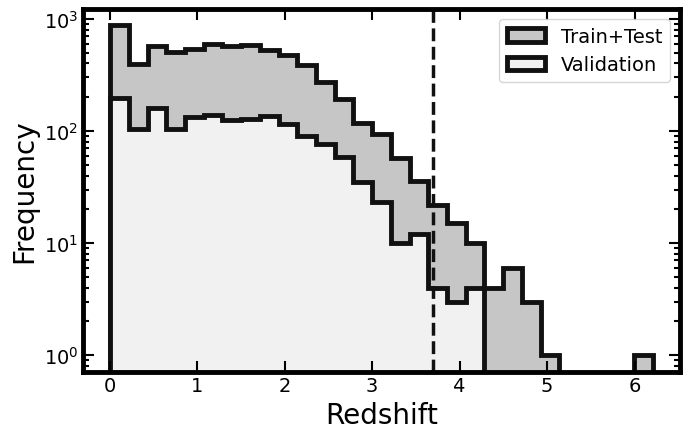

In [19]:
fig             = plt.figure(figsize=(7,4.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, target_feat])
max_score  = np.nanmax(full_catalog_df.loc[:, target_feat])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(train_test_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Train+Test')
ax1.hist(validation_df.loc[:, target_feat], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='Validation')

ax1.axvline(x=3.7, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Save indices of sources in validation sub-set for future steps.

In [20]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use Correlation matrix to discard some features

In [21]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [22]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [23]:
rsd_vals

z_y         310.966140
i_z         253.244252
K_W3        212.477336
i_y         167.196896
r_i         139.584595
W1_W2       134.155901
g_r         118.173271
r_z         113.408866
r_y         109.079886
g_i          98.627995
g_z          89.530402
g_y          88.621066
H_W3         70.152723
Z            66.280465
y_W1         64.840897
z_W1         58.296775
J_W3         56.616933
y_W2         55.159213
i_W1         54.876160
r_W1         54.297274
g_W1         54.260731
y_J          52.239443
z_W2         48.834010
z_J          47.685864
y_H          46.984967
i_J          45.806295
i_W2         45.715297
r_W2         43.884964
g_W2         43.321863
z_H          43.187078
r_J          43.059930
i_H          41.789020
W1_W3        40.751065
g_J          40.708291
W2_W3        40.594992
y_K          40.343280
r_H          39.687561
g_H          38.010230
z_K          37.533209
i_K          36.614656
H_K          35.198398
r_K          34.842270
J_H          34.207025
g_K        

In [24]:
correlation = norm_train_test_df.corr()

In [25]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [26]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [27]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [28]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [29]:
list_drop_corr

['g_H',
 'r_H',
 'y_H',
 'i_H',
 'J_W1',
 'z_H',
 'J_W2',
 'J_W3',
 'Jmag',
 'J_W4',
 'g_K',
 'y_K',
 'r_K',
 'i_K',
 'H_W1',
 'z_K',
 'H_W2',
 'Kmag',
 'rmag',
 'zmag',
 'W2mproPM',
 'K_W1',
 'r_W4',
 'i_W4',
 'W2_W4',
 'H_W3',
 'r_J',
 'W1mproPM',
 'gmag',
 'i_J',
 'g_W2',
 'imag',
 'ymag',
 'r_W3',
 'z_W4',
 'J_K',
 'g_W4',
 'i_W3',
 'W1_W4',
 'y_W4',
 'z_J',
 'r_W1',
 'H_W4',
 'W2_W3',
 'r_W2',
 'z_W3',
 'i_W2',
 'i_W1',
 'y_W2',
 'z_W2',
 'Hmag',
 'W3mag',
 'g_z',
 'g_W3',
 'g_y',
 'g_i',
 'z_W1',
 'y_W3',
 'r_y',
 'K_W2',
 'W3_W4']

In [30]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [31]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [32]:
corr_discard = norm_train_test_discard.corr()

In [33]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

Z         Z           1.000000
y_J       g_J         0.747526
          band_num    0.722021
W4mag     K_W3        0.699869
z_y       i_y         0.686586
K_W4      K_W3        0.685105
y_W1      g_W1        0.656637
W1_W3     Z           0.652195
band_num  H_K         0.636162
r_i       r_z         0.635700
r_z       i_z         0.626342
g_r       g_W1        0.624409
W1_W3     y_J         0.619692
          band_num    0.598810
g_J       g_W1        0.585116
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

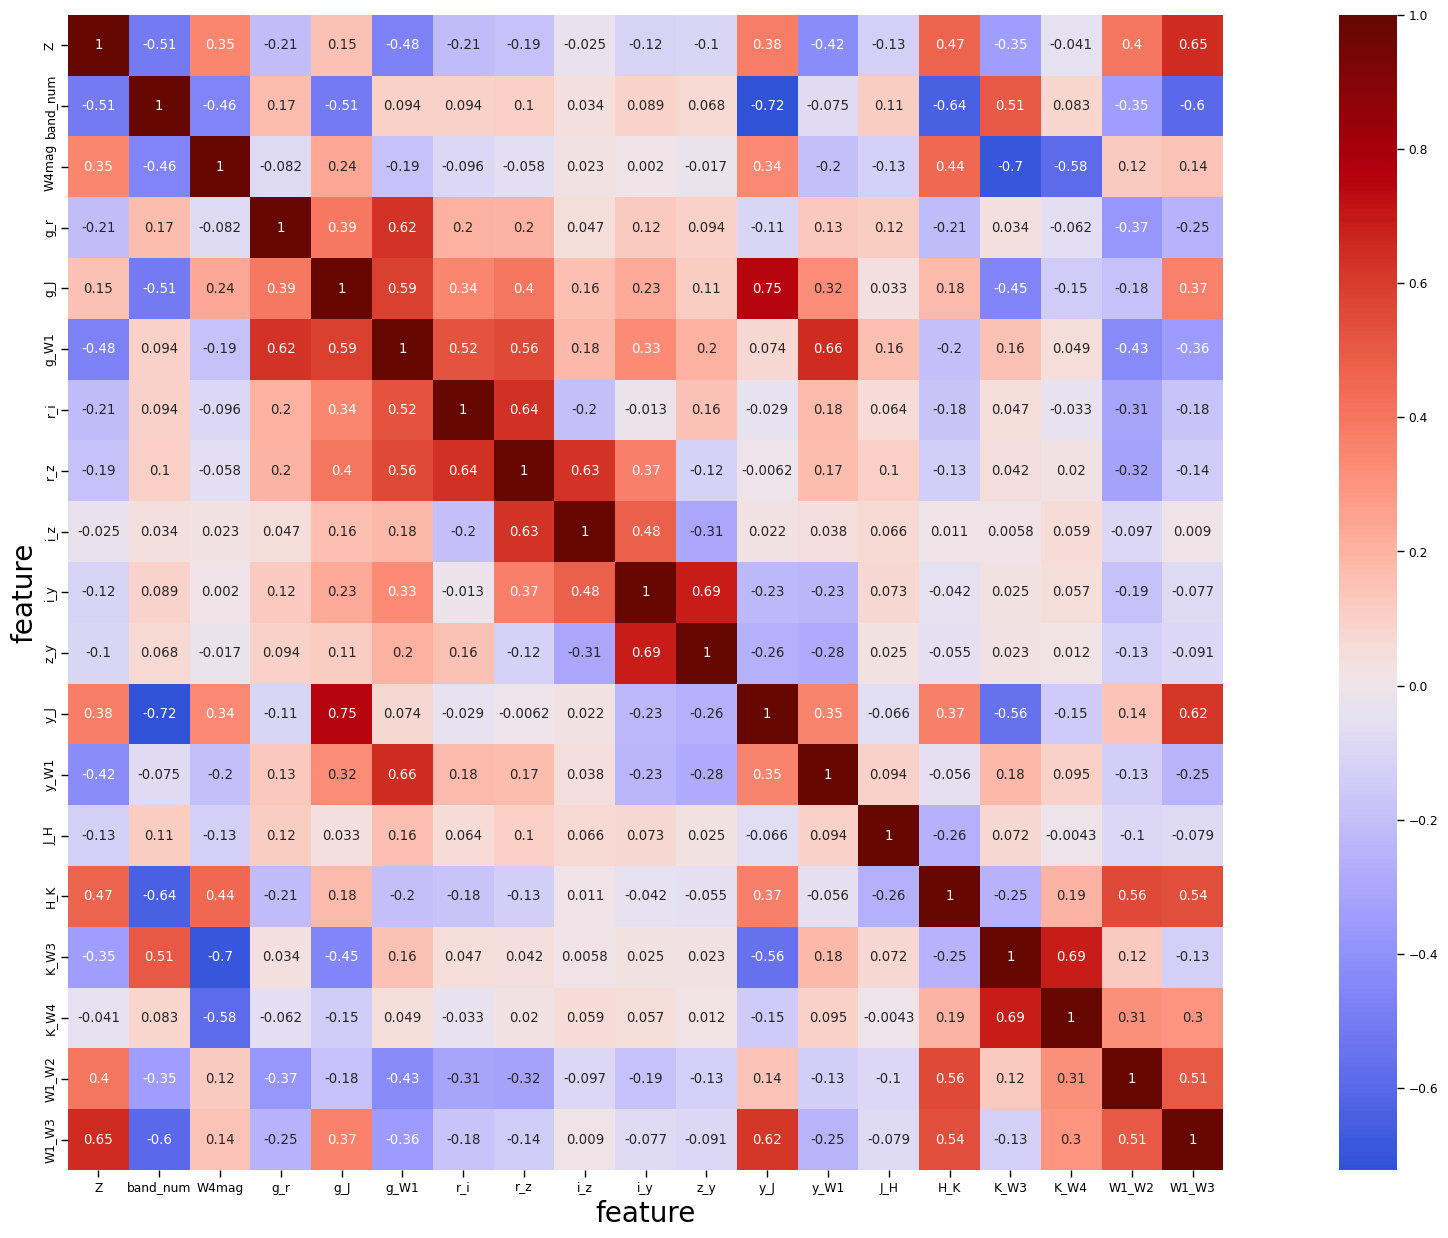

In [34]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [35]:
# norm_train_test_discard.loc[:, target_feat] = norm_train_test_discard.loc[:, target_feat].astype(bool)

In [36]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=gv.seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [37]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x         y       
H_K       H_K         1.000000
J_H       band_num    0.453098
Z         H_K         0.448211
H_K       band_num    0.443836
band_num  y_J         0.438583
K_W4      W4mag       0.431603
J_H       H_K         0.401951
K_W4      K_W3        0.356431
W4mag     K_W3        0.300987
K_W3      K_W4        0.259966
y_J       band_num    0.252157
band_num  H_K         0.237824
K_W4      band_num    0.230529
K_W3      y_J         0.208297
          W4mag       0.202340
y_J       g_J         0.201436
K_W4      H_K         0.194128
band_num  W1_W3       0.187193
          Z           0.182397
W4mag     band_num    0.181676
dtype: float64

In [38]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [39]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [40]:
list_drop_pps = []

In [41]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [42]:
list_drop_pps

[]

In [43]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [44]:
pps_pred_target = pps.predictors(norm_train_test_discard, target_feat, random_seed=gv.seed)

In [45]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,band_num,Z,0.182397,regression,True,mean absolute error,0.114438,0.093565,DecisionTreeRegressor()
1,H_K,Z,0.176864,regression,True,mean absolute error,0.114438,0.094198,DecisionTreeRegressor()
2,J_H,Z,0.174250,regression,True,mean absolute error,0.114438,0.094497,DecisionTreeRegressor()
3,K_W4,Z,0.146129,regression,True,mean absolute error,0.114438,0.097715,DecisionTreeRegressor()
4,W1_W3,Z,0.142263,regression,True,mean absolute error,0.114438,0.098158,DecisionTreeRegressor()
5,W4mag,Z,0.086693,regression,True,mean absolute error,0.114438,0.104517,DecisionTreeRegressor()
6,W1_W2,Z,0.046240,regression,True,mean absolute error,0.114438,0.109147,DecisionTreeRegressor()
7,K_W3,Z,0.031263,regression,True,mean absolute error,0.114438,0.110861,DecisionTreeRegressor()
8,g_r,Z,0.000000,regression,True,mean absolute error,0.114438,0.135189,DecisionTreeRegressor()
9,g_J,Z,0.000000,regression,True,mean absolute error,0.114438,0.150875,DecisionTreeRegressor()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [46]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta

In [47]:
feats_2_discard = list_drop_corr + list_drop_pps

Boruta discards one feature.

In [48]:
exp_radio = pyr.setup(data=train_df, test_data=test_df, target=target_feat, session_id=gv.seed, silent=True,\
                      feature_selection=False, feature_selection_method='boruta',\
                      numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                      transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                      normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,Z
2,Original Data,"(5515, 80)"
3,Missing Values,False
4,Numeric Features,18
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(5515, 18)"


In [49]:
pyr.get_config('X').columns

Index(['band_num', 'W4mag', 'g_r', 'g_J', 'g_W1', 'r_i', 'r_z', 'i_z', 'i_y',
       'z_y', 'y_J', 'y_W1', 'J_H', 'H_K', 'K_W3', 'K_W4', 'W1_W2', 'W1_W3'],
      dtype='object')

In [50]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


Add custom metrics

In [51]:
pyr.add_metric('s_mad',  'sigma_mad',    gf.sigma_mad,    greater_is_better=False)
pyr.add_metric('s_nmad', 'sigma_nmad',   gf.sigma_nmad,   greater_is_better=False)
pyr.add_metric('s_z',    'sigma_z',      gf.sigma_z,      greater_is_better=False)
pyr.add_metric('s_z_n',  'sigma_z_norm', gf.sigma_z_norm, greater_is_better=False)
pyr.add_metric('out_f',  'outlier_fr',   gf.outlier_frac, greater_is_better=False)

Name                                                        outlier_fr
Display Name                                                outlier_fr
Score Function               <function outlier_frac at 0x7f0c9d3378b0>
Scorer               make_scorer(outlier_frac, greater_is_better=Fa...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: out_f, dtype: object

In [52]:
metric_2_opt          = 's_mad'
final_selection_reg   = ['rf', 'et', 'catboost', 'xgboost', 'gbr', 'dummy']  # knn discarded: no feature importances
initial_selection_reg = ['rf', 'et', 'gbr', 'xgboost', 'catboost', 'dummy']  # Only tree-based models (except lightgbm, dt)
n_models              = 5
top_model_z           = pyr.compare_models(n_select=n_models, include=final_selection_reg, sort=metric_2_opt)  # 1:15 hour for used_models_clf
# top_model_z           = pyr.compare_models(n_select=n_models, include=initial_selection_reg, sort=metric_2_opt)  # 5 minutes, using all models.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr,TT (Sec)
rf,Random Forest Regressor,0.2471,0.1891,0.4333,0.7506,0.1727,0.3754,0.1717,0.0772,0.4333,0.2024,0.2051,0.6570
et,Extra Trees Regressor,0.2477,0.1831,0.4266,0.7585,0.1671,0.3802,0.1899,0.0863,0.4266,0.1885,0.2100,0.3450
catboost,CatBoost Regressor,0.2579,0.1753,0.4181,0.7679,0.1675,0.4833,0.2173,0.1044,0.4181,0.1891,0.2310,0.5960
xgboost,Extreme Gradient Boosting,0.2713,0.1918,0.4368,0.7472,0.1762,0.4917,0.2319,0.1079,0.4368,0.2006,0.2390,9.3770
gbr,Gradient Boosting Regressor,0.3081,0.2231,0.4716,0.7054,0.1894,0.5968,0.2869,0.1357,0.4716,0.2114,0.3079,0.2200
dummy,Dummy Regressor,0.7139,0.7590,0.8708,-0.0030,0.3986,3.1220,0.9693,0.3957,0.8708,0.5009,0.7157,0.0060


Thus, we select `rf` as meta learner. It has the best scores in sigma_mad, sigma_nmad and outlier fraction.  
These are the values we care the most about.

Thus, we stack the models.

In [53]:
stacked_model_z = pyr.stack_models(estimator_list=top_model_z[1:], meta_model=top_model_z[0], optimize=metric_2_opt)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2439,0.1819,0.4265,0.7283,0.1718,0.3439,0.1829,0.0821,0.4265,0.2083,0.2156
1,0.2052,0.1400,0.3742,0.7978,0.1549,0.3127,0.1365,0.0631,0.3742,0.2030,0.1612
2,0.2155,0.1381,0.3717,0.8230,0.1452,0.2459,0.1691,0.0714,0.3717,0.1533,0.1703
3,0.2333,0.1820,0.4266,0.7537,0.1628,0.3168,0.1523,0.0702,0.4266,0.1740,0.1667
4,0.2224,0.1669,0.4085,0.7841,0.1619,0.3647,0.1437,0.0669,0.4085,0.1798,0.1848
5,0.2381,0.1774,0.4212,0.7741,0.1650,0.3865,0.1666,0.0732,0.4212,0.1885,0.1869
6,0.2200,0.1648,0.4059,0.7821,0.1631,0.3422,0.1462,0.0641,0.4059,0.1886,0.1688
7,0.2491,0.2171,0.4660,0.7378,0.1687,0.3386,0.1712,0.0741,0.4660,0.2117,0.1851
8,0.2298,0.1707,0.4132,0.7820,0.1627,0.3171,0.1510,0.0674,0.4132,0.1824,0.1869


In [54]:
tuned_z_reg = pyr.tune_model(stacked_model_z, early_stopping=True, optimize=metric_2_opt,\
                             search_library='tune-sklearn', search_algorithm='bayesian', choose_better=True)  # 1h30

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.2289,0.1698,0.4121,0.7464,0.1636,0.3021,0.1706,0.0727,0.4121,0.1967,0.1685
1,0.1958,0.1313,0.3624,0.8103,0.1496,0.2655,0.1279,0.0580,0.3624,0.1815,0.1413
2,0.2116,0.1384,0.3720,0.8227,0.1448,0.2402,0.1631,0.0684,0.3720,0.1524,0.1649
3,0.2315,0.1862,0.4315,0.7480,0.1634,0.2760,0.1382,0.0650,0.4315,0.1594,0.1757
4,0.2135,0.1584,0.3980,0.7951,0.1542,0.3164,0.1320,0.0643,0.3980,0.1649,0.1685
5,0.2320,0.1749,0.4182,0.7773,0.1614,0.3295,0.1631,0.0731,0.4182,0.1820,0.1742
6,0.2193,0.1705,0.4129,0.7745,0.1635,0.2884,0.1392,0.0619,0.4129,0.1820,0.1742
7,0.2427,0.2193,0.4683,0.7352,0.1671,0.3144,0.1523,0.0668,0.4683,0.2091,0.1724
8,0.2168,0.1653,0.4065,0.7890,0.1527,0.2445,0.1276,0.0582,0.4065,0.1613,0.1670


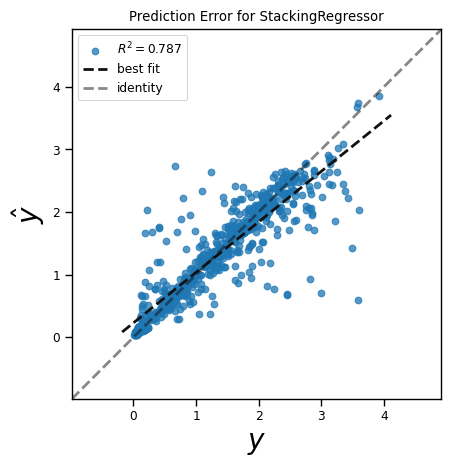

In [55]:
pyr.plot_model(tuned_z_reg, plot='error')

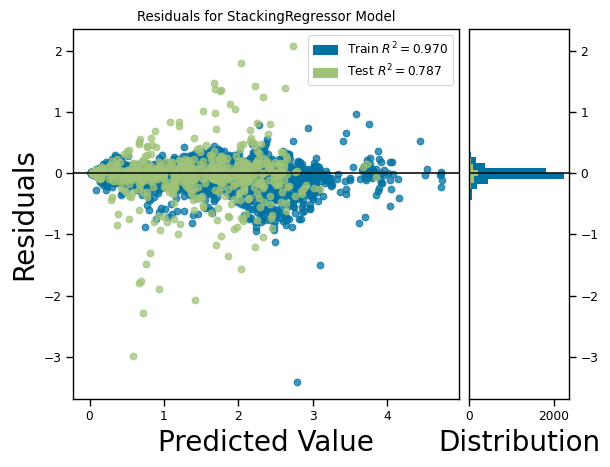

In [56]:
pyr.plot_model(tuned_z_reg, plot='residuals')

In [77]:
# pyr.plot_model(tuned_z_reg.final_estimator_, plot='feature_all')

In [57]:
pyr.plot_model(tuned_z_reg.final_estimator_, plot='parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
criterion,mae
max_depth,9
max_features,0.6346363645439446
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,3.221765456072098e-08
min_impurity_split,None
min_samples_leaf,5


In [58]:
pyr.plot_model(tuned_z_reg.final_estimator, plot='parameter')

,Parameters
bootstrap,False
ccp_alpha,0.0
criterion,mae
max_depth,9
max_features,0.6346363645439446
max_leaf_nodes,None
max_samples,None
min_impurity_decrease,3.221765456072098e-08
min_impurity_split,None
min_samples_leaf,5


In [59]:
plt.rcParams.update(plt.rcParamsDefault)

In [60]:
pyr.predict_model(tuned_z_reg).loc[:, [target_feat, 'Label']].describe()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2209,0.1648,0.4060,0.7872,0.1659,0.2817,0.1430,0.0623,0.4060,0.1828,0.1629


,Z,Label
count,657.000000,657.000000
mean,1.356472,1.323894
std,0.880673,0.799977
min,0.015000,0.030749
25%,0.607000,0.660008
50%,1.314000,1.314578
75%,2.044000,2.021088
max,3.920000,3.853190


In [61]:
test_prediction_reg = pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2209,0.1648,0.4060,0.7872,0.1659,0.2817,0.1430,0.0623,0.4060,0.1828,0.1629


In [62]:
final_z_reg = pyr.finalize_model(tuned_z_reg)

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: Futur

In [63]:
pyr.predict_model(final_z_reg).loc[:, [target_feat, 'Label']].describe()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2209,0.1648,0.4060,0.7872,0.1659,0.2817,0.1430,0.0623,0.4060,0.1828,0.1629


,Z,Label
count,657.000000,657.000000
mean,1.356472,1.323894
std,0.880673,0.799977
min,0.015000,0.030749
25%,0.607000,0.660008
50%,1.314000,1.314578
75%,2.044000,2.021088
max,3.920000,3.853190


In [64]:
if save_model_flag:
    pyr.save_model(final_z_reg, gv.models_path + gv.full_z_model)  # Model (it will be saved with .pkl extension)

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [49]:
if load_model_flag:
    final_z_reg = pyr.load_model(gv.models_path + gv.full_z_model)

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [66]:
base_models_names = gf.get_base_estimators_names(final_z_reg)
base_models       = gf.get_base_estimators_models(final_z_reg)

In [67]:
print('Running data pre-processing:\n')
extended_data_z_df = gf.preprocess_data(final_z_reg, validation_df, base_models_names)

Running data pre-processing:



In [68]:
coef_sorted_meta_df = gf.feat_importances_meta_model(final_z_reg, extended_data_z_df)

In [69]:
coef_sorted_base_df = gf.feat_importances_base_models(base_models_names, base_models, extended_data_z_df)

In [70]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [71]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for et...
Calculating for catboost...
Calculating for xgboost...
Calculating for gbr...


et             catboost              xgboost                  gbr  \
     Feature Importance   Feature Importance   Feature Importance   Feature   
0      W1_W3  23.635157      y_W1  18.711236       H_K  32.630112     W1_W3   
1       y_W1  12.902527     W1_W3  18.306822     W1_W3  28.516623      y_W1   
2   band_num  10.174475     W1_W2  11.832986      y_W1   7.597255       H_K   
3      W1_W2   8.663117       g_r   8.390603     W4mag   7.096167     W4mag   
4      W4mag   7.979115       r_z   5.073814     W1_W2   3.538494     W1_W2   
5       g_W1   7.145283       z_y   4.905658       z_y   2.365311       g_r   
6        g_r   4.951738      g_W1   4.753118       y_J   2.232432      g_W1   
7        y_J   3.324660       H_K   4.278328      K_W4   2.178128  band_num   
8        r_z   3.149870  band_num   4.187763  band_num   1.720045       y_J   
9        H_K   3.134799       r_i   3.409997       g_r   1.690985       z_y   
10       r_i   3.007148       i_y   3.270438       r_z   1.673767       r_i   
11       z_y   2.684432       i_z   2.941835      K_W3   1.537792       r_z   
12       i_y   2.464804       y_J   2.833094       i_y   1.441884       i_y   
13       i_z   2.196147     W4mag   2.532004       i_z   1.339785       i_z   
14       g_J   2.175386       g_J   1.689718      g_W1   1.287528      K_W3   
15      K_W3   1.474505      K_W3   1.541199       r_i   1.169962      K_W4   
16      K_W4   0.491870      K_W4   0.914838       g_J   1.017642       g_J   
17       J_H   0.444968       J_H   0.426550       J_H   0.966089       J_H   

               
   Importance  
0   49.813812  
1   15.307708  
2    6.829041  
3    5.351574  
4    5.168857  
5    4.117686  
6    2.859499  
7    2.710391  
8    2.481524  
9    1.898240  
10   0.800522  
11   0.705388  
12   0.630194  
13   0.549719  
14   0.456724  
15   0.158507  
16   0.100849  
17   0.059764

In [72]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,gbr,52.239231
1,xgboost,22.380555
2,catboost,8.851928
3,et,2.960622
4,H_K,1.954453
5,g_r,1.879679
6,r_i,1.579826
7,W1_W2,1.386887
8,i_z,1.282604
9,z_y,1.016080


Feature importances scaled to sum 100
--------------------
top features:
Feature	Importance
W1_W3	18.764
y_W1	18.514
W1_W2	11.657
g_r	8.251
r_z	4.980
z_y	4.830
g_W1	4.724
H_K	4.567
band_num	4.208
r_i	3.359
i_y	3.219
i_z	2.896
y_J	2.829
W4mag	2.657
g_J	1.672
K_W3	1.530
K_W4	0.916
J_H	0.428


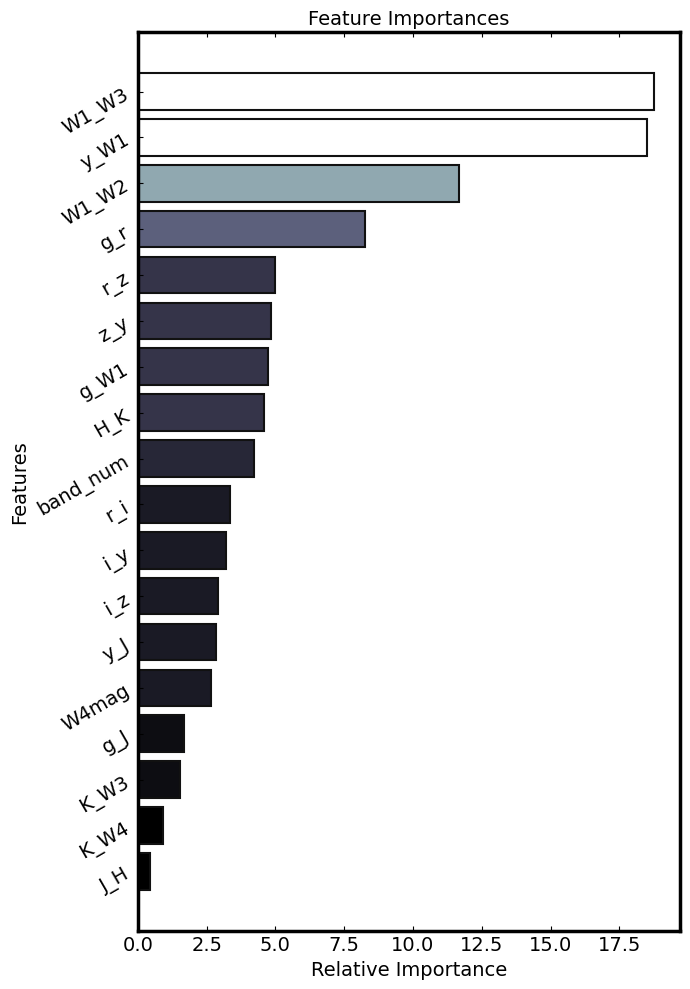

In [73]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = gf.get_feature_importances_df(final_z_reg, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        plt.savefig(gv.plots_path + 'feat_imp_regression_z_04.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

#### List optimised hyperparameters

In [74]:
hyperparams_models_df = gf.obtain_optimised_hyperpars(final_z_reg, 'rf', 'regression')
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(hyperparams_models_df)

,rf,et,catboost,xgboost,gbr
n_estimators,187,100.0000,NaN,100.0000,100.0000
max_depth,9,NaN,NaN,6.0000,3.0000
min_impurity_decrease,0.0000,0.0000,NaN,NaN,0.0000
max_features,0.6346,auto,NaN,NaN,None
bootstrap,False,False,NaN,NaN,NaN
criterion,mae,mse,NaN,NaN,NaN
min_samples_split,3,2.0000,NaN,NaN,2.0000
min_samples_leaf,5,1.0000,NaN,NaN,1.0000
learning_rate,NaN,NaN,0.0536,0.3000,0.1000
depth,NaN,NaN,6.0000,NaN,NaN


---

In [75]:
print(f'Size of train set is {len(train_df):,}')
print(f'Size of test set is  {len(test_df):,}')

Size of train set is 5,515
Size of test set is  657


In [76]:
train_prediction_reg      = pyr.predict_model(final_z_reg, data=train_df)
test_prediction_reg       = pyr.predict_model(final_z_reg, data=test_df)
train_test_prediction_reg = pyr.predict_model(final_z_reg, data=train_test_df)
calib_prediction_reg      = pyr.predict_model(final_z_reg, data=calibration_df)
validation_prediction_reg = pyr.predict_model(final_z_reg, data=validation_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0812,0.0224,0.1496,0.9705,0.0510,0.0881,0.0619,0.0286,0.1496,0.0494,0.0228


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2209,0.1648,0.4060,0.7872,0.1659,0.2817,0.1430,0.0623,0.4060,0.1828,0.1629


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1090,0.0530,0.2302,0.9306,0.0853,0.1240,0.0722,0.0331,0.2302,0.0899,0.0487


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2253,0.1925,0.4387,0.7583,0.1597,0.2621,0.1496,0.0675,0.4387,0.1709,0.1477


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2352,0.1739,0.4170,0.7722,0.1672,0.3089,0.1595,0.0716,0.4170,0.2007,0.1739


In [77]:
validation_prediction_reg.loc[:, [target_feat, 'Label']].describe()

,Z,Label
count,1662.000000,1662.000000
mean,1.335170,1.327526
std,0.873968,0.792155
min,0.003000,0.023602
25%,0.557500,0.679652
50%,1.279000,1.294691
75%,1.944750,1.937939
max,4.247000,4.036778


In [79]:
sigma_mad_train         = gf.sigma_mad(train_prediction_reg.loc[:, target_feat],         train_prediction_reg.loc[:, 'Label'])
sigma_mad_test          = gf.sigma_mad(test_prediction_reg.loc[:, target_feat],          test_prediction_reg.loc[:, 'Label'])
sigma_mad_train_test    = gf.sigma_mad(train_test_prediction_reg.loc[:, target_feat],    train_test_prediction_reg.loc[:, 'Label'])
sigma_mad_calib         = gf.sigma_mad(calib_prediction_reg.loc[:, target_feat],         calib_prediction_reg.loc[:, 'Label'])
sigma_mad_valid         = gf.sigma_mad(validation_prediction_reg.loc[:, target_feat],    validation_prediction_reg.loc[:, 'Label'])

In [80]:
sigma_nmad_train        = gf.sigma_nmad(train_prediction_reg.loc[:, target_feat],        train_prediction_reg.loc[:, 'Label'])
sigma_nmad_test         = gf.sigma_nmad(test_prediction_reg.loc[:, target_feat],         test_prediction_reg.loc[:, 'Label'])
sigma_nmad_train_test   = gf.sigma_nmad(train_test_prediction_reg.loc[:, target_feat],   train_test_prediction_reg.loc[:, 'Label'])
sigma_nmad_calib        = gf.sigma_nmad(calib_prediction_reg.loc[:, target_feat],        calib_prediction_reg.loc[:, 'Label'])
sigma_nmad_valid        = gf.sigma_nmad(validation_prediction_reg.loc[:, target_feat],   validation_prediction_reg.loc[:, 'Label'])

In [81]:
sigma_z_train           = gf.sigma_z(train_prediction_reg.loc[:, target_feat],           train_prediction_reg.loc[:, 'Label'])
sigma_z_test            = gf.sigma_z(test_prediction_reg.loc[:, target_feat],            test_prediction_reg.loc[:, 'Label'])
sigma_z_train_test      = gf.sigma_z(train_test_prediction_reg.loc[:, target_feat],      train_test_prediction_reg.loc[:, 'Label'])
sigma_z_calib           = gf.sigma_z(calib_prediction_reg.loc[:, target_feat],           calib_prediction_reg.loc[:, 'Label'])
sigma_z_valid           = gf.sigma_z(validation_prediction_reg.loc[:, target_feat],      validation_prediction_reg.loc[:, 'Label'])

In [82]:
sigma_z_norm_train      = gf.sigma_z_norm(train_prediction_reg.loc[:, target_feat],      train_prediction_reg.loc[:, 'Label'])
sigma_z_norm_test       = gf.sigma_z_norm(test_prediction_reg.loc[:, target_feat],       test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_train_test = gf.sigma_z_norm(train_test_prediction_reg.loc[:, target_feat], train_test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_calib      = gf.sigma_z_norm(calib_prediction_reg.loc[:, target_feat],      calib_prediction_reg.loc[:, 'Label'])
sigma_z_norm_valid      = gf.sigma_z_norm(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'])

In [83]:
out_frac_train          = gf.outlier_frac(train_prediction_reg.loc[:, target_feat],      train_prediction_reg.loc[:, 'Label'])
out_frac_test           = gf.outlier_frac(test_prediction_reg.loc[:, target_feat],       test_prediction_reg.loc[:, 'Label'])
out_frac_train_test     = gf.outlier_frac(train_test_prediction_reg.loc[:, target_feat], train_test_prediction_reg.loc[:, 'Label'])
out_frac_calib          = gf.outlier_frac(calib_prediction_reg.loc[:, target_feat],      calib_prediction_reg.loc[:, 'Label'])
out_frac_valid          = gf.outlier_frac(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'])

Display metrics as DataFrame

In [84]:
metrics_z = np.array([[len(train_prediction_reg),      sigma_mad_train,      sigma_nmad_train,\
                       sigma_z_train,      sigma_z_norm_train,      out_frac_train],\
                      [len(test_prediction_reg),       sigma_mad_test,       sigma_nmad_test,\
                       sigma_z_test,       sigma_z_norm_test,       out_frac_test],\
                      [len(train_test_prediction_reg), sigma_mad_train_test, sigma_nmad_train_test,\
                       sigma_z_train_test, sigma_z_norm_train_test, out_frac_train_test],\
                      [len(calib_prediction_reg),      sigma_mad_calib,      sigma_nmad_calib,\
                       sigma_z_calib,      sigma_z_norm_calib,      out_frac_calib],\
                      [len(validation_prediction_reg), sigma_mad_valid,      sigma_nmad_valid,\
                       sigma_z_valid,      sigma_z_norm_valid,      out_frac_valid]])

In [85]:
metrics_z_df = pd.DataFrame(data=metrics_z, index=['Train', 'Test', 'Train+Test', 'Calibration', 'Validation'],\
                            columns=['Sample', '\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'])

In [86]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    metrics_z_df.loc[:, 'Sample'] = metrics_z_df.loc[:, 'Sample'].astype(int)
    display(metrics_z_df)

,Sample,σ MAD,σ NMAD,σ z,σ z N,η
Train,5515,0.0619,0.0286,0.1496,0.0494,0.0228
Test,657,0.1430,0.0623,0.4060,0.1828,0.1629
Train+Test,6856,0.0722,0.0331,0.2302,0.0899,0.0487
Calibration,684,0.1496,0.0675,0.4387,0.1709,0.1477
Validation,1662,0.1595,0.0716,0.4170,0.2007,0.1739


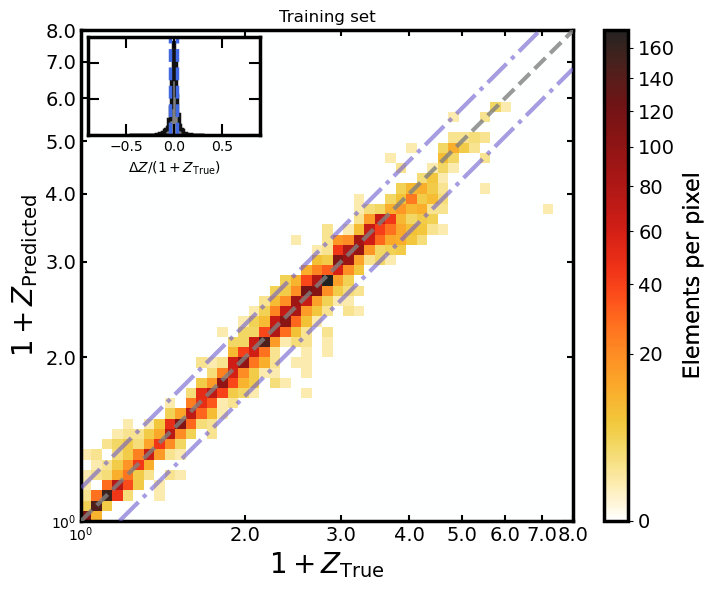

In [87]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(train_prediction_reg.loc[:, target_feat], train_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Training set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_train_redshift_04.pdf', bbox_inches='tight')
plt.show()

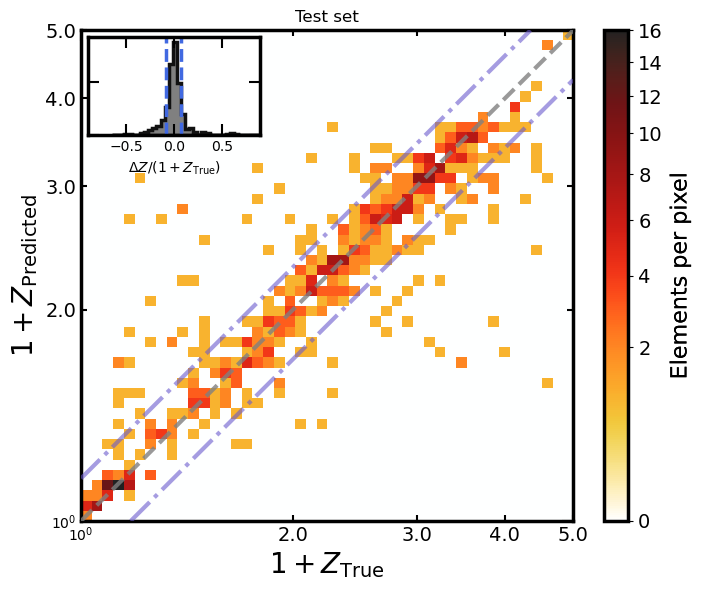

In [88]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(test_prediction_reg.loc[:, target_feat], test_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Test set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_test_redshift_04.pdf', bbox_inches='tight')
plt.show()

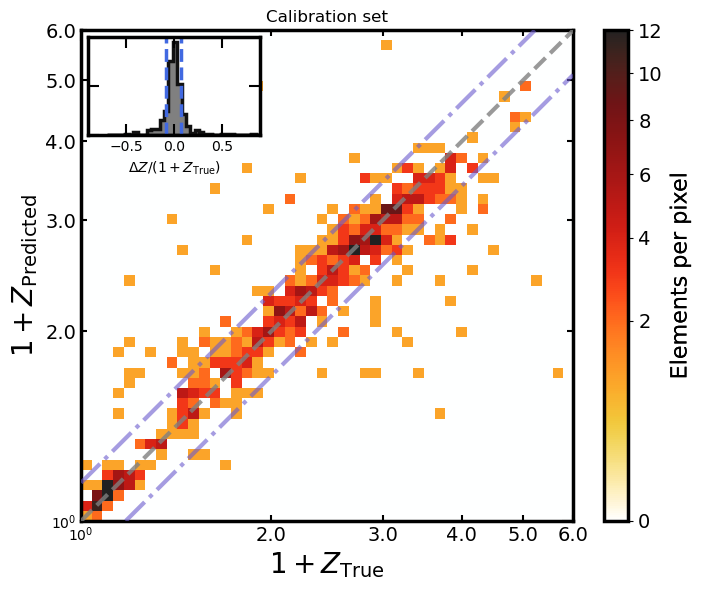

In [89]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(calib_prediction_reg.loc[:, target_feat], calib_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Calibration set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_calibration_redshift_04.pdf', bbox_inches='tight')
plt.show()

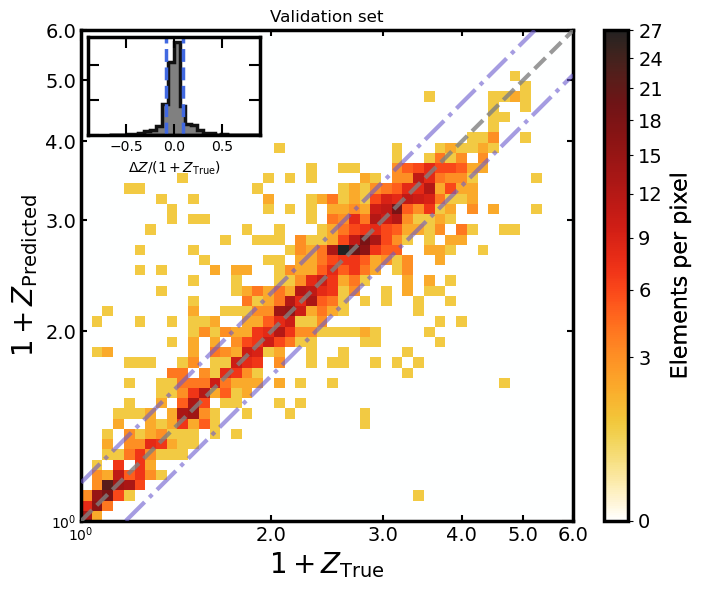

In [78]:
# visualize the embedding
fig             = plt.figure(figsize=(7.5,6))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
_ = gf.plot_redshift_compare(validation_prediction_reg.loc[:, target_feat], validation_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Validation set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    plt.savefig(gv.plots_path + 'compare_plot_validation_redshift_04.pdf', bbox_inches='tight')
plt.show()

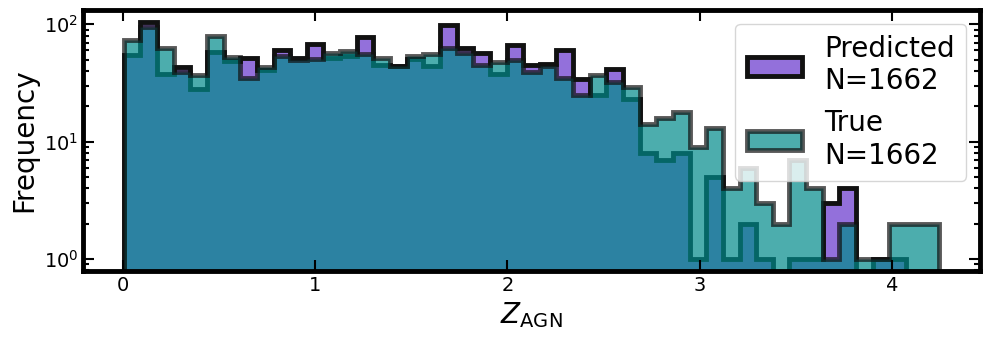

In [90]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(validation_prediction_reg.loc[:, target_feat]),\
                           np.nanmin(validation_prediction_reg.loc[:, 'Label'])])
max_for_range = np.nanmax([np.nanmax(validation_prediction_reg.loc[:, target_feat]),\
                           np.nanmax(validation_prediction_reg.loc[:, 'Label'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)

_, bins, _ = ax1.hist(validation_prediction_reg.loc[:, 'Label'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"Predicted\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Label'] > 0))}")
ax1.hist(validation_prediction_reg.loc[:, target_feat], bins=bins_z, histtype='stepfilled', ec='k', fc='darkcyan',\
         lw=3.5, label=f"True\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Z'] > 0))}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$Z_{\mathrm{AGN}}$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=20)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'hist_true_predicted_z_04.pdf')
plt.show()

---

#### Redshift threshold

In order to understand where (in redshift) the predictions are far off from real values, we can use the evolution of the outlier fraction to obtain the point where that happens.

In [91]:
n_elems        = 50
z_range_lin    = np.linspace(0, np.nanmax(train_test_prediction_reg.loc[:, target_feat]), n_elems)
z_range_log    = np.logspace(np.log10(np.abs(np.nanmin(train_test_prediction_reg.loc[:, target_feat]))),\
                          np.log10(np.abs(np.nanmax(train_test_prediction_reg.loc[:, target_feat]))), n_elems)
z_range_lg_inv = np.abs(np.abs(np.nanmax(train_test_prediction_reg.loc[:, target_feat]))) - z_range_log

In [92]:
train_test_prediction_reg = train_test_prediction_reg.rename(columns={'Label': 'pred_Z'})

In [93]:
s_MAD_z_z_lin          = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_mad,      target_feat,            'pred_Z')
s_NMAD_z_z_lin         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_nmad,     target_feat,            'pred_Z')
sigma_z_z_z_lin        = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_z,        target_feat,            'pred_Z')
sigma_z_N_z_z_lin      = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.sigma_z_norm,   target_feat,            'pred_Z')
out_fr_z_z_lin         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lin, gf.outlier_frac,   target_feat,            'pred_Z')

In [94]:
s_MAD_z_z_log          = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_mad,      target_feat,            'pred_Z')
s_NMAD_z_z_log         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_nmad,     target_feat,            'pred_Z')
sigma_z_z_z_log        = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_z,        target_feat,            'pred_Z')
sigma_z_N_z_z_log      = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.sigma_z_norm,   target_feat,            'pred_Z')
out_fr_z_z_log         = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_log, gf.outlier_frac,   target_feat,            'pred_Z')

In [95]:
s_MAD_z_z_log_inv      = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_mad,      target_feat,            'pred_Z')
s_NMAD_z_z_log_inv     = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_nmad,     target_feat,            'pred_Z')
sigma_z_z_z_log_inv    = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_z,        target_feat,            'pred_Z')
sigma_z_N_z_z_log_inv  = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.sigma_z_norm,   target_feat,            'pred_Z')
out_fr_z_z_log_inv     = z_metric_in_z_ranges(train_test_prediction_reg, target_feat, z_range_lg_inv, gf.outlier_frac,   target_feat,            'pred_Z')

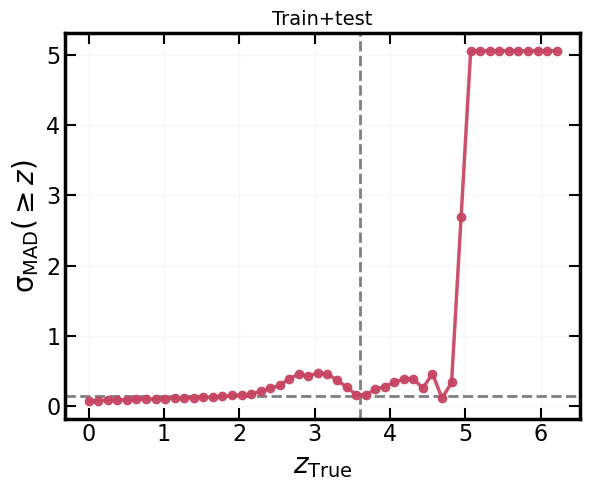

In [96]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, s_MAD_z_z_lin, '\sigma_{MAD}', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'sigma_mad_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

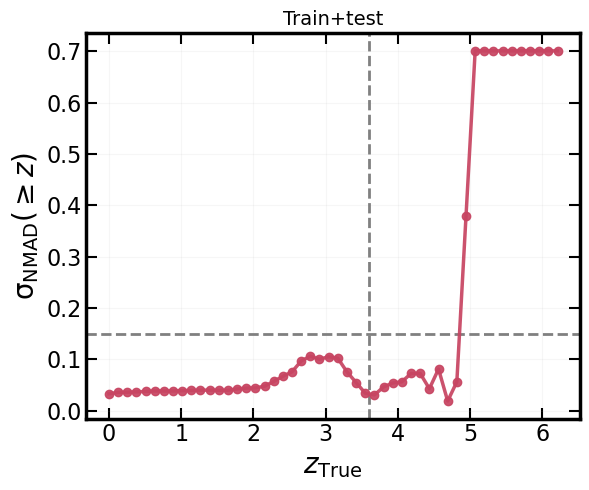

In [97]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, s_NMAD_z_z_lin, '\sigma_{NMAD}', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'sigma_nmad_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

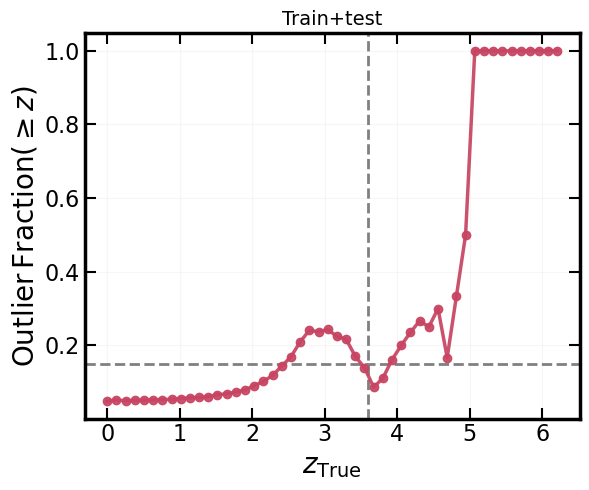

In [98]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lin, out_fr_z_z_lin, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'outlier_fraction_linear_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

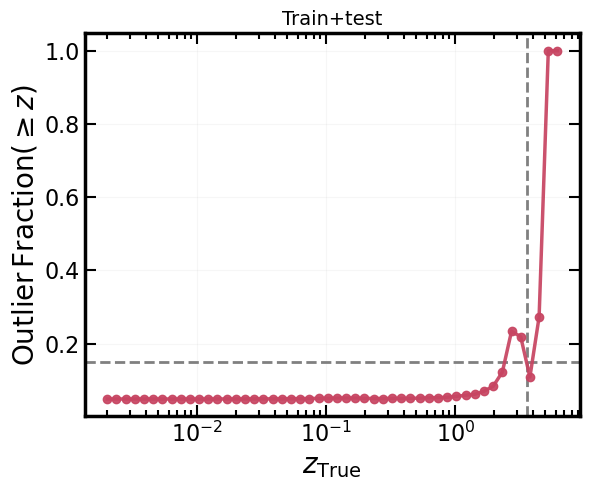

In [99]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='log', yscale='linear')
plot_metric_over_z(z_range_log, out_fr_z_z_log, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'outlier_fraction_log_redshift_redshift_train_test.pdf', bbox_inches='tight')
plt.show()

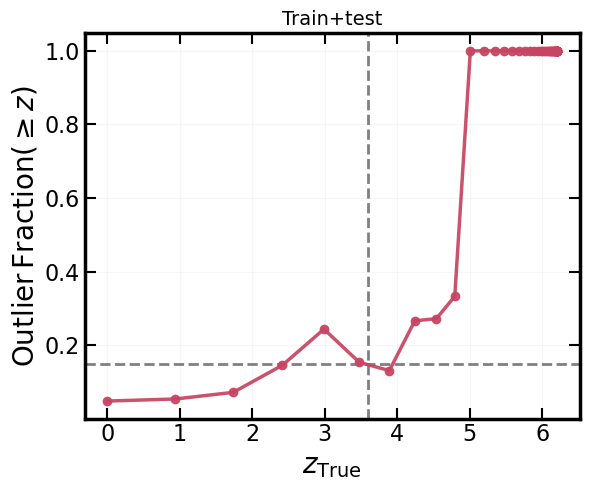

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.Custom logger is already specified. Specify more than one logger at same time is not thread safe.

In [100]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
plot_metric_over_z(z_range_lg_inv, out_fr_z_z_log_inv, 'Outlier\,Fraction', ax1, title='Train+test')
# ax1.axhline(y=0.10, ls='--', c='Gray', lw=2.0)
ax1.axhline(y=0.15, ls='--', c='Gray', lw=2.0)
ax1.axvline(x=3.60, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.20, ls='--', c='Gray', lw=2.0)
# ax1.axhline(y=0.50, ls='--', c='Gray', lw=2.0)
fig.tight_layout()
if save_plot_flag:
    plt.savefig(gv.plots_path + 'outlier_fraction_inv_log_redshift_redshift_train_test.pdf', bbox_inches='tight')
plt.show()